In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from vessel_training_utils import (
    show_images, iou_metric, sum_params, training_loop, 
    save_model, plot_evaluation, model_out
)
from vess_map_custom_cnn import CustomResNet
import sys
sys.path.append("../data/")
from vess_map_dataset_loader import vess_map_dataloader

# Setting up GPU
torch.cuda.empty_cache()
device = torch.device("cuda")

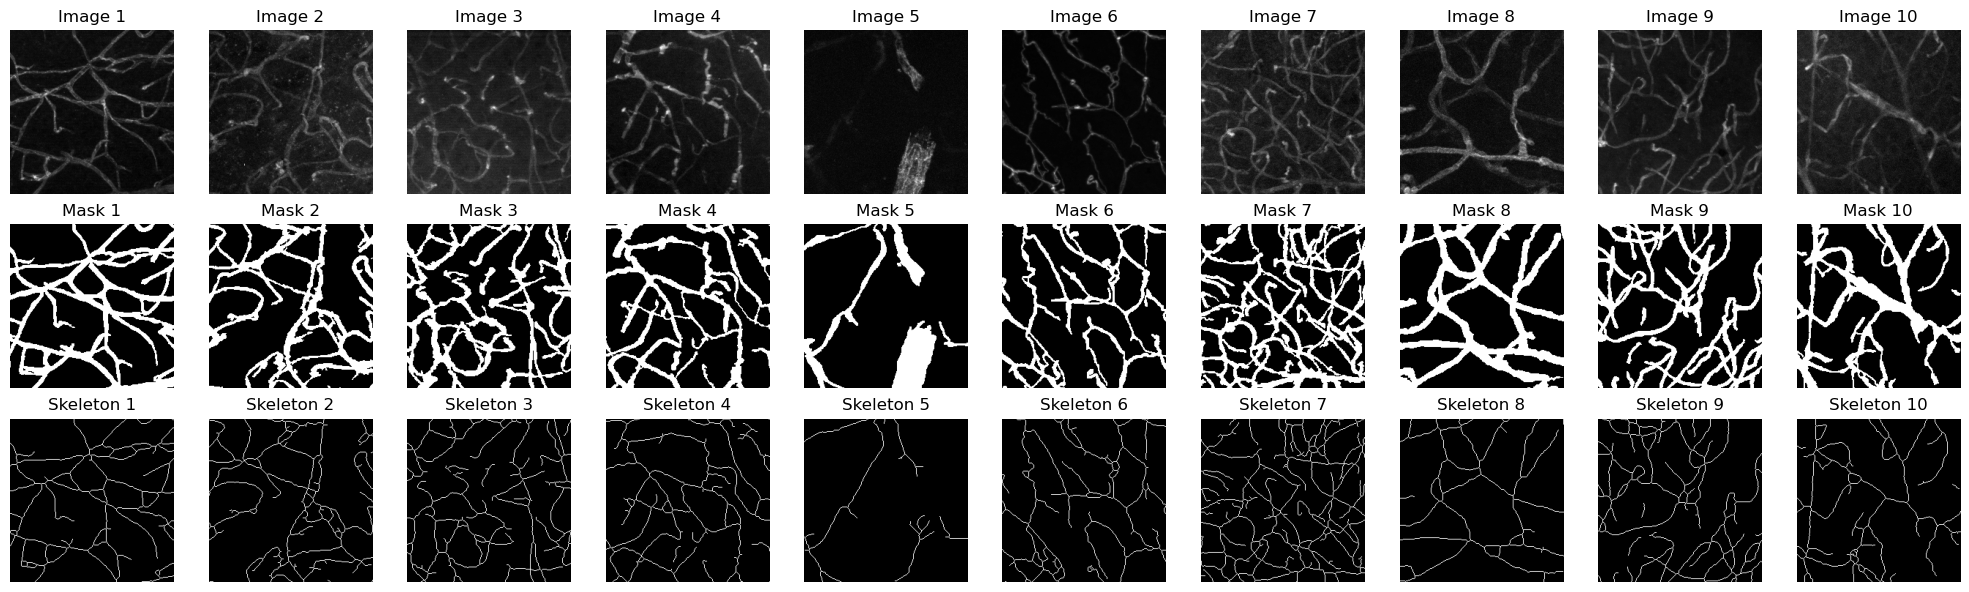

In [2]:
# Data directories
image_dir = '../data/VessMap/images'
mask_dir = '../data/VessMap/labels'
skeleton_dir = '../data/VessMap/skeletons'

# DataLoader setup
batch_size = 10
train_size = 0.8
image_size = 224

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size,
                                  image_size)

# Show images
show_images(train_loader, num_sets=10)

In [3]:
# Initialize metrics
train_losses = []
train_aux_losses = []
test_losses = []
test_accuracies = []
test_ious = []

In [4]:
# Hyperparameters
alpha_l1 = 0.00001
alpha_l2 = 0.00001
regularization_mode = 'none'
num_epochs = 50
weight_decay = 1e-4

In [5]:
# Model, criterion, optimizer, and scheduler
model = CustomResNet(num_classes=2).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

/home/fonta42/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
# Training the model
training_loop(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, regularization_mode, alpha_l1, alpha_l2, train_losses, train_aux_losses, test_losses, test_accuracies, test_ious)

Epoch [1/50] Train Loss: 0.5166 Aux Loss: 0.0000 Test Loss: 0.5865 Train IoU: 0.3004 Test IoU: 0.0000
Epoch [2/50] Train Loss: 0.3739 Aux Loss: 0.0000 Test Loss: 1.0450 Train IoU: 0.4949 Test IoU: 0.0000
Epoch [3/50] Train Loss: 0.2835 Aux Loss: 0.0000 Test Loss: 1.0872 Train IoU: 0.6146 Test IoU: 0.0020
Epoch [4/50] Train Loss: 0.2349 Aux Loss: 0.0000 Test Loss: 0.8603 Train IoU: 0.6905 Test IoU: 0.0277
Epoch [5/50] Train Loss: 0.2326 Aux Loss: 0.0000 Test Loss: 0.5800 Train IoU: 0.6844 Test IoU: 0.1554
Epoch [6/50] Train Loss: 0.2230 Aux Loss: 0.0000 Test Loss: 0.3444 Train IoU: 0.7042 Test IoU: 0.4763
Epoch [7/50] Train Loss: 0.2034 Aux Loss: 0.0000 Test Loss: 0.3516 Train IoU: 0.7210 Test IoU: 0.4795
Epoch [8/50] Train Loss: 0.1888 Aux Loss: 0.0000 Test Loss: 0.2755 Train IoU: 0.7351 Test IoU: 0.5926
Epoch [9/50] Train Loss: 0.1702 Aux Loss: 0.0000 Test Loss: 0.2546 Train IoU: 0.7616 Test IoU: 0.6374
Epoch [10/50] Train Loss: 0.1649 Aux Loss: 0.0000 Test Loss: 0.2124 Train IoU: 0.7

In [11]:
# Save the model
model_name = f'vess_map_custom_cnn'
save_model(model, f'./trained-models/{model_name}.pth', regularization_mode)

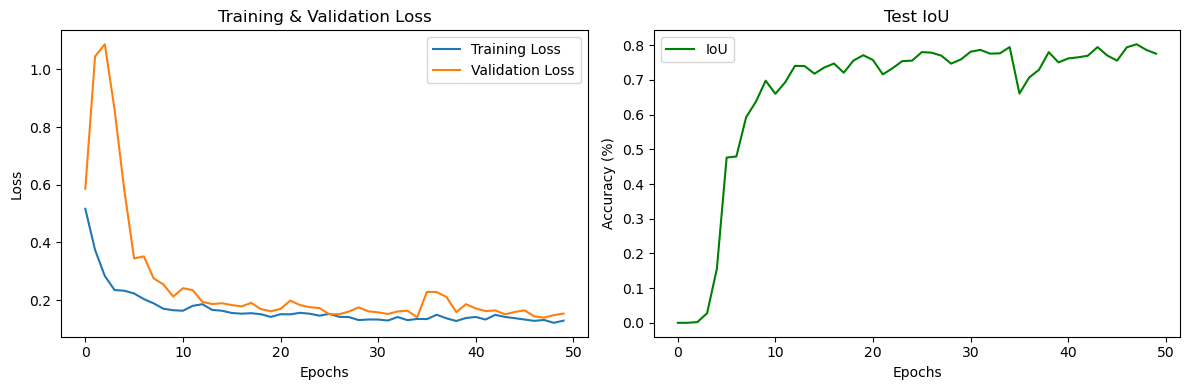

In [12]:
# Plot evaluation results
plot_evaluation(train_losses, train_aux_losses, test_losses, test_ious, regularization_mode, num_epochs, f'./evaluation-results/{model_name}.png')

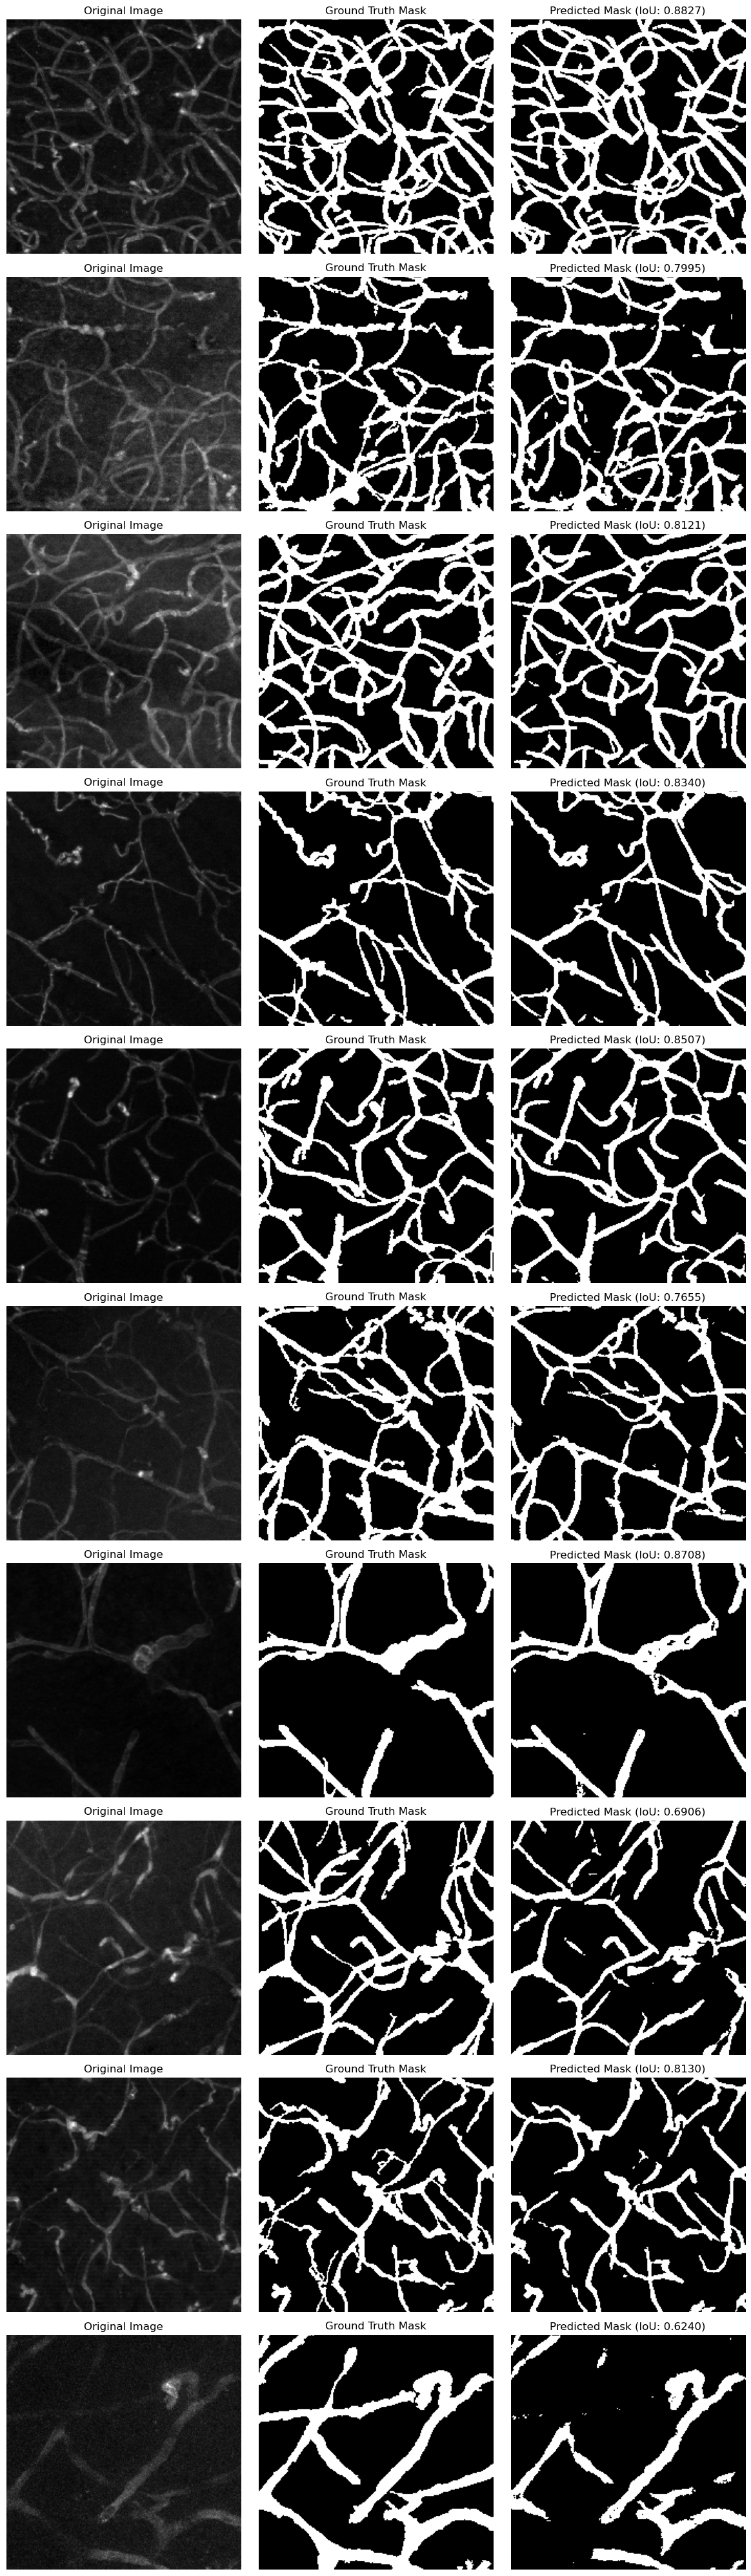

In [13]:
# Output model predictions
model_out(model, test_loader)